In [1]:
import os
import glob
import os.path
import re
import pickle
import datetime

import pandas as pd

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

import matplotlib.pyplot as plt

+ 强制全部输出间隔一致

In [2]:
class AtChem2Case:
    def __init__(self, mDir, facfile = None):
        assert os.path.exists(mDir)
        self.modelpath = mDir
        
        self.facfile = facfile
        if not facfile:
            self.facfile = glob.glob(f"{mDir}/*.fac")[0]
        
        self.mechDG = self._init_DG_from_fac(self.facfile)
        self.frames = {}


        self.resolve_configuration()
        if os.path.exists(f"{mDir}/output"):
            self.resolve_output(f"{mDir}/output")

    def _init_DG_from_fac(self, facfile: str):
        assert os.path.exists(facfile)

        lines = open(facfile).read().splitlines()
        lines_reaction = [L for L in lines if L.startswith("% ")]
        reactions = list(map(lambda x: re.search(': (.*) ;', x).group(1).replace(' ', ''), lines_reaction))
    
        for iL, L in enumerate(lines):
            if L == 'VARIABLE':
                break
        iL += 1
        variables = []
        while not lines[iL].startswith('******************'):
            variables.extend([ele for ele in re.split(r'[; ]', lines[iL]) if ele.strip()])
            iL += 1

        
        DG = nx.DiGraph()
        DG.species = []
        DG.reactions = []
        for i_sp, sp in enumerate(variables):
            DG.add_node(sp, type="species", spe_id=i_sp+1)
            DG.species.append(DG.nodes[sp])
        for i_reac, reac in enumerate(reactions):
            DG.add_node(reac, type="reaction", reac_id=i_reac+1)
            DG.reactions.append(DG.nodes[reac])
            
            reactants = re.findall(r"\w+", reac.split('=')[0])
            products = re.findall(r"\w+", reac.split('=')[1])
            for rtt in reactants:
                DG.add_edge(rtt, reac)
            for pdt in products:
                DG.add_edge(reac, pdt)

        self.variables = variables
        self.reactions = reactions
        
        return DG    

    def resolve_configuration(self):
        for k, v in self.get_model_parameters().items():
            setattr(self, k, v)
        self.timezone = -float(self.lon) / 15
        self.startDatetime = datetime.datetime.strptime(f"""{self.year}/{self.month}/{self.day}""", "%Y/%m/%d")
        self.startDatetime += datetime.timedelta(hours=self.timezone)
        self.startDatetime += datetime.timedelta(seconds=int(self.starttime))
        self.timeseries = [self.startDatetime]
        timestep = datetime.timedelta(seconds=int(self.dt))
        for i in range(int(self.nsteps)):
            self.timeseries.append(self.timeseries[-1] + timestep)
        
    def get_model_parameters(self):
        configfile = os.path.join(self.modelpath, "configuration/model.parameters")
        model_params_lines = [L.split()[0] for L in open(configfile, "r").read().splitlines()]
        keys_by_order = ("nsteps", "dt", "species_interp_method", "condition_interp_method", "dt_out", "starttime", "dt_jacobian_out", 
                         "lat", "lon", "day", "month", "year", "dt_rrate_out")
        model_parameters = {keys_by_order[i]:model_params_lines[i] for i in range(len(model_params_lines))}
        return model_parameters

    def prepare_frames(self):
        self.frames = {}
        for i_dtm, dtm in enumerate(self.timeseries):
            frameT = self.copyDG()
            frameT.graph["datetime"] = dtm
            frameT.graph["step_index"] = i_dtm
            frameT.graph["step_second"] = i_dtm * self.dt
            
            self.frames[dtm] = frameT

    def copyDG(self):
        DG = self.mechDG.copy()
        DG.species = [None]
        DG.reactions = [None]
        for sp in self.variables:
            DG.species.append(DG.nodes[sp])
        for reac in self.reactions:
            DG.reactions.append(DG.nodes[reac])
        return DG
    
    def resolve_output(self, oDir: str):
        self.prepare_frames()
        spe_conc_file = f"{self.modelpath}/output/speciesConcentrations.output"
        reac_rate_dir = f"{self.modelpath}/output/reactionRates"
        self._resolve_conc(spe_conc_file)
        self._resolve_rate(reac_rate_dir)
        pass

    def _resolve_conc(self, conc_file: str):
        df = pd.read_csv(conc_file, index_col=0, sep=r'\s+')
        
        for t in df.index:
            frameG = self[t]
            for v in df.columns:
                frameG.nodes[v]["conc"] = df.loc[t, v]

    def _resolve_rate(self, rate_dir: str):
        rate_dir = f"{self.modelpath}/output/reactionRates"
        
        for i in range(1, int(self.nsteps)+1):
            rate_file = f"{rate_dir}/{i*int(self.dt)}"
            frameG = self.get_frame_from_idx(i)
        
            df = pd.read_csv(rate_file, index_col=0, sep=r"\s+")
            for rid in df.index:
                # print(rid)
                frameG.reactions[rid]["rate"] = df.loc[rid, "reactionRate"]

    def _get_output_times(self):
        dfT = pd.read_csv(f'{self.modelpath}/speciesConcentrations.output', sep=r'\s+', index_col=0)
        outdts = []
        for t in dfT.index:
            outdts.append(startDatetime + datetime.timedelta(seconds=int(t)))
        return outdts
    
    def __getitem__(self, idx):
        if not hasattr(self, "frames"):
            print("No frames in this case now!")
            return
            
        if isinstance(idx, datetime.datetime):
            return self.frames[time]
        
        try:
            dt = int(self.dt)
            idx = int(idx)
            if idx % dt == 0:
                return self.frames[self.timeseries[idx//dt]]
            else:
                print("No target seconds!")
                return
        except:
            print("Failed to get frame from seconds")
            return
            
    def get_frame_from_idx(self, idx: int):
        return self.frames[self.timeseries[idx]]

    def _get_conc(self, vn: str):
        concs = []
        for dtm, dg in self.frames.items():
            val = dg.nodes[vn]["conc"]
            concs.append(val)
        return concs
    
    def plot_conc(self, vns: list[str]):
        fig, axs = plt.subplots(len(vns), 1, figsize=(12, 5))
        if len(vns) > 1:
            for i, v in enumerate(vns):
                axs[i].plot(self.timeseries, self._get_conc(v))
        else:
            axs.plot(self.timeseries, self._get_conc(vns[0]))

In [3]:
rct = AtChem2Case("/home/roadelse/Model/AtChem2/AtChem2-1.2.2/model")

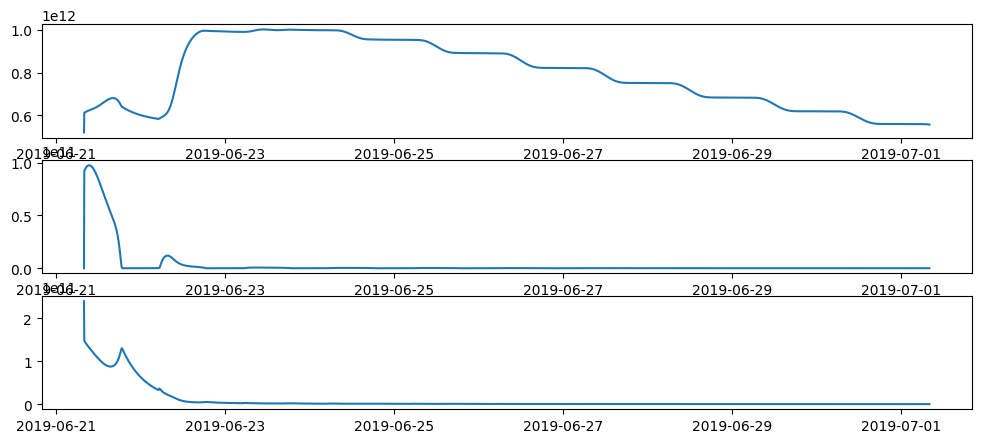

In [4]:
rct.plot_conc(["O3", "NO", "NO2"])

In [6]:
pickle.dump(rct, open("case.pk", "wb"))

In [159]:
rct[300].reactions[1]

{'type': 'reaction', 'reac_id': 2, 'rate': 270295800.0}

# 思考一下
+ 现在以及基本解析完了conc和rate, 那么, 我的目的是什么?
    + 首先, 我得看看default case下, 为什么是这么变得...
+ 基本的出图肯定也是要有的